# Hard disk failure prediction using boosted trees

In [1]:
import numpy as np 
import pandas as pd 
from pandas.plotting import table 

import datetime

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from numpy import mean
from numpy import std


import warnings
warnings.filterwarnings('ignore')

### Data load and explore

In [2]:
#data source: https://www.kaggle.com/backblaze/hard-drive-test-data
hDData = pd.read_csv('/Users/bala/Documents/EdgeAnalytics/harddrive.csv')

In [3]:
hDData['date'] = pd.to_datetime(hDData['date'])
#hDData['date']=hDData['date'].dt.date
print(hDData['date'].max())
print(hDData['date'].min())

2016-04-29 00:00:00
2016-01-01 00:00:00


In [4]:
hDData.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#extracting models with failures for analysis
hDDataModelValCounts = hDData.model.value_counts()
hDDataModelValCounts = pd.DataFrame(hDDataModelValCounts).reset_index()
hDDataModelValCounts.columns = ['model', 'modelCount']
hDDataFailByModelCounts = hDData[hDData['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp = pd.merge(hDDataModelValCounts.reset_index(), hDDataFailByModelCounts.reset_index(), on = 'model')
hDDataFailByModelProp['failPercent'] = (hDDataFailByModelProp['failure']/hDDataFailByModelProp['modelCount'])*100
hDDataFailByModelProp.sort_values('failPercent', ascending = False,inplace=True)
hDDataFailByModelProp[:10]

,index,model,modelCount,failure,failPercent
24,59,WDC WD3200BEKT,32,1,3.125000
22,40,WDC WD1600AAJB,195,2,1.025641
19,31,WDC WD800AAJS,708,6,0.847458
23,44,WDC WD800BB,138,1,0.724638
12,18,ST320LT007,2687,15,0.558243
21,39,WDC WD800AAJB,200,1,0.500000
20,32,WDC WD3200BEKX,534,1,0.187266
18,28,WDC WD10EADS,1342,2,0.149031
17,25,ST3160318AS,2299,2,0.086994
10,14,WDC WD20EFRX,6871,3,0.043662


In [6]:
#trimming the dataset - IMPORTANT: devices 'serial_number' that have never failed are also included 
modelList = hDData['model'][hDData['failure']==1].value_counts().sort_values(ascending=False)[:25]
df = hDData[hDData['model'].isin(hDDataFailByModelProp['model'][:25])]
print('Updated dataset shape',df.shape)
print('Some of the devices, in the trimmed dataset, that have never failed')
df['serial_number'][df['failure']==0].value_counts().sort_values(ascending=False)[:25]


Updated dataset shape (3051256, 95)
Some of the devices, in the trimmed dataset, that have never failed


Z304HT20           52
Z3029BDT           52
Z304JVYN           52
JK11A8B9HZ1G8F     52
PL1331LAGSAMLH     52
Z3029FJK           52
Z304JBEC           52
WD-WCC4N0828669    52
Z1Z05Q75           52
Z305AR0N           52
Z300CNAN           52
PL1311LAG26KNA     52
JK11A8B9J2X65F     52
MJ0351YNGA3SUA     52
Z4D04H1T           52
MJ1311YNG6T95A     52
JK11A8B9J8E2EF     52
PL2331LAGN6RBJ     52
PL2331LAGUKL5J     52
MJ0351YNG9ZE8A     52
MJ1323YNG1SEPC     52
W3009RCX           52
Z30252HB           52
S300896V           52
Z300H9CL           52
Name: serial_number, dtype: int64

In [7]:
#devices are added and removed from the dataset, with or without failure. It's unclear why the the same 'serial_number' and 'date' appear more than once.
#in any case, the following code slices out device survival during the various intervals recorded

#https://stackoverflow.com/questions/53305411/how-to-find-gaps-in-dates-using-pandas
# Convert date to true dates
#df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
#df['date'] = df['date'].dt.date
grp = df.groupby(by='serial_number')
# Starts of periods
st = grp.apply(lambda x: x.date[x.date - pd.DateOffset(days = 1)
    != x.date.shift()]).reset_index(level=1,drop=True)
# Ends of periods
en = grp.apply(lambda x: x.date[x.date + pd.DateOffset(days = 1)
    != x.date.shift(-1)]).reset_index(level=1,drop=True)
# Result - concat start / end dates
res = pd.concat([st, en], axis=1).reset_index()
# Set column names
res.columns = ['serial_number', 'start', 'end']
res

,serial_number,start,end
0,13H2B97AS,2016-01-01,2016-01-01
1,13H2B97AS,2016-01-01,2016-01-21
2,13H2B97AS,2016-04-01,2016-04-01
3,13H2B97AS,2016-04-01,2016-04-29
4,13H32WEAS,2016-01-01,2016-01-01
...,...,...,...
233503,Z4D29XNF,2016-04-01,2016-04-29
233504,Z4D2B5EC,2016-01-01,2016-01-01
233505,Z4D2B5EC,2016-01-01,2016-01-21
233506,Z4D2B5EC,2016-04-01,2016-04-01


In [8]:
#adding back the details needed
df1 = pd.merge(res,df[['model','serial_number','failure','date']], left_on=['serial_number','end'],right_on=['serial_number','date'], how='left').drop(['date'], axis='columns')
df1['duration'] = df1['end']-df1['start']
df1['duration'] = df1.duration.dt.days
print(df1['end'].max())
print(df1['end'].min())
df1

2016-04-29 00:00:00
2016-01-01 00:00:00


,serial_number,start,end,model,failure,duration
0,13H2B97AS,2016-01-01,2016-01-01,TOSHIBA DT01ACA300,0,0
1,13H2B97AS,2016-01-01,2016-01-01,TOSHIBA DT01ACA300,0,0
2,13H2B97AS,2016-01-01,2016-01-21,TOSHIBA DT01ACA300,0,20
3,13H2B97AS,2016-04-01,2016-04-01,TOSHIBA DT01ACA300,0,0
4,13H2B97AS,2016-04-01,2016-04-01,TOSHIBA DT01ACA300,0,0
...,...,...,...,...,...,...
349106,Z4D2B5EC,2016-01-01,2016-01-01,ST6000DX000,0,0
349107,Z4D2B5EC,2016-01-01,2016-01-21,ST6000DX000,0,20
349108,Z4D2B5EC,2016-04-01,2016-04-01,ST6000DX000,0,0
349109,Z4D2B5EC,2016-04-01,2016-04-01,ST6000DX000,0,0


Exploring data size, number of failures, list of models, proportion of failures by model

In [9]:
topFew = 40

In [10]:
hDData.model.value_counts()[:topFew]

ST4000DM000                1681473
HGST HMS5C4040ALE640        368077
Hitachi HDS5C3030ALA630     236690
Hitachi HDS722020ALA330     224052
HGST HMS5C4040BLE640        186832
Hitachi HDS5C4040ALE630     136969
ST6000DX000                  97864
WDC WD30EFRX                 54686
Hitachi HDS723030ALA640      51940
ST500LM012 HN                31412
WDC WD60EFRX                 23816
WDC WD5000LPVX               14706
ST4000DX000                  10847
TOSHIBA MD04ABA400V           7570
WDC WD20EFRX                  6871
WDC WD1600AAJS                5003
ST31500541AS                  4428
HGST HDS5C4040ALE630          3615
ST320LT007                    2687
ST9250315AS                   2686
ST3160316AS                   2480
TOSHIBA DT01ACA300            2435
WDC WD40EFRX                  2392
TOSHIBA MD04ABA500V           2340
HGST HUH728080ALE600          2340
ST3160318AS                   2299
HGST HDS724040ALE640          2080
ST250LM004 HN                 1683
WDC WD10EADS        

In [11]:
hDDataModelValCounts = hDData.model.value_counts()
hDDataModelValCounts = pd.DataFrame(hDDataModelValCounts).reset_index()
hDDataModelValCounts.columns = ['model', 'modelCount']
hDDataFailByModelCounts = hDData[hDData['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp = pd.merge(hDDataModelValCounts.reset_index(), hDDataFailByModelCounts.reset_index(), on = 'model')
hDDataFailByModelProp['failPercent'] = (hDDataFailByModelProp['failure']/hDDataFailByModelProp['modelCount'])*100
hDDataFailByModelProp.sort_values('failPercent', ascending = False,inplace=True)
hDDataFailByModelProp[:topFew]


,index,model,modelCount,failure,failPercent
24,59,WDC WD3200BEKT,32,1,3.125000
22,40,WDC WD1600AAJB,195,2,1.025641
19,31,WDC WD800AAJS,708,6,0.847458
23,44,WDC WD800BB,138,1,0.724638
12,18,ST320LT007,2687,15,0.558243
21,39,WDC WD800AAJB,200,1,0.500000
20,32,WDC WD3200BEKX,534,1,0.187266
18,28,WDC WD10EADS,1342,2,0.149031
17,25,ST3160318AS,2299,2,0.086994
10,14,WDC WD20EFRX,6871,3,0.043662


In [12]:
#hDData1 = hDData[hDData.model.isin(hDData[hDData['failure'] == 1].groupby('model')['failure'].count().sort_values()[-5:].index)]
hDData1 = hDData[hDData.model.isin(hDDataFailByModelProp['model'][:topFew])]
print(hDData1.shape)
print(hDData1.model.unique())

(3051256, 95)
['Hitachi HDS5C3030ALA630' 'ST4000DM000' 'WDC WD30EFRX'
 'Hitachi HDS5C4040ALE630' 'HGST HMS5C4040ALE640' 'HGST HMS5C4040BLE640'
 'ST6000DX000' 'Hitachi HDS722020ALA330' 'ST4000DX000' 'WDC WD60EFRX'
 'WDC WD1600AAJS' 'ST320LT007' 'TOSHIBA MD04ABA500V' 'TOSHIBA DT01ACA300'
 'ST3160318AS' 'WDC WD20EFRX' 'ST9250315AS' 'ST3160316AS' 'WDC WD800AAJS'
 'WDC WD3200BEKX' 'WDC WD1600AAJB' 'WDC WD800AAJB' 'WDC WD3200BEKT'
 'WDC WD800BB' 'WDC WD10EADS']


Feature engineering to extract serial number wise survival duration.

In [13]:
hDData_dates_event = hDData1.groupby('serial_number').agg({'date': [min,max], 'failure': max})
hDData_dates_event

date            failure
                     min        max     max
serial_number                              
13H2B97AS     2016-01-01 2016-04-29       0
13H32WEAS     2016-01-01 2016-04-29       0
13H6A21GS     2016-01-01 2016-04-29       0
13H7X2HAS     2016-01-01 2016-04-29       0
13H85BMGS     2016-01-01 2016-04-29       0
...                  ...        ...     ...
Z4D1X9LF      2016-01-01 2016-04-29       0
Z4D1XXJX      2016-01-01 2016-04-29       0
Z4D1XY09      2016-01-01 2016-04-29       0
Z4D29XNF      2016-01-01 2016-04-29       0
Z4D2B5EC      2016-01-01 2016-04-29       0

[63197 rows x 3 columns]

In [14]:
hDData_dates_event.columns = list(map(''.join, hDData_dates_event.columns.values))
print(hDData_dates_event.failuremax.sum())
hDData_dates_event

205


,datemin,datemax,failuremax
serial_number,,,
13H2B97AS,2016-01-01,2016-04-29,0
13H32WEAS,2016-01-01,2016-04-29,0
13H6A21GS,2016-01-01,2016-04-29,0
13H7X2HAS,2016-01-01,2016-04-29,0
13H85BMGS,2016-01-01,2016-04-29,0
...,...,...,...
Z4D1X9LF,2016-01-01,2016-04-29,0
Z4D1XXJX,2016-01-01,2016-04-29,0
Z4D1XY09,2016-01-01,2016-04-29,0


In [15]:
hDData_dates_event['failDate'] = ""
hDData_dates_event['failDate'] = hDData_dates_event['datemax'][hDData_dates_event['failuremax']==1]
print(hDData_dates_event.shape)
print(hDData_dates_event.head())
print(hDData_dates_event[~pd.isnull(hDData_dates_event.failDate)])
print(hDData_dates_event[~pd.isnull(hDData_dates_event.failDate)].shape)

(63197, 4)
                 datemin    datemax  failuremax failDate
serial_number                                           
13H2B97AS     2016-01-01 2016-04-29           0      NaT
13H32WEAS     2016-01-01 2016-04-29           0      NaT
13H6A21GS     2016-01-01 2016-04-29           0      NaT
13H7X2HAS     2016-01-01 2016-04-29           0      NaT
13H85BMGS     2016-01-01 2016-04-29           0      NaT
                  datemin    datemax  failuremax   failDate
serial_number                                              
13H883WAS      2016-01-01 2016-04-20           1 2016-04-20
6VMX70TB       2016-01-01 2016-04-04           1 2016-04-04
9VY8TC9H       2016-01-01 2016-04-18           1 2016-04-18
9VY8TCAV       2016-01-01 2016-04-09           1 2016-04-09
JK1101B9GEJEUF 2016-01-01 2016-04-21           1 2016-04-21
...                   ...        ...         ...        ...
Z305GV9E       2016-04-01 2016-04-20           1 2016-04-20
Z305K26M       2016-04-01 2016-04-20           1 2

In [16]:
#hDData_dates_event.reset_index()
hDData_dates_event1 = pd.merge(hDData_dates_event.reset_index(), hDData[['model','serial_number']], on='serial_number', how='left')
print(hDData_dates_event1.head())
print(hDData_dates_event1.shape)
hDData_dates_event1.drop_duplicates(inplace=True)
print(hDData_dates_event1.head())
print(hDData_dates_event1.shape)
print(hDData_dates_event1.failuremax.sum())


serial_number    datemin    datemax  failuremax failDate               model
0     13H2B97AS 2016-01-01 2016-04-29           0      NaT  TOSHIBA DT01ACA300
1     13H2B97AS 2016-01-01 2016-04-29           0      NaT  TOSHIBA DT01ACA300
2     13H2B97AS 2016-01-01 2016-04-29           0      NaT  TOSHIBA DT01ACA300
3     13H2B97AS 2016-01-01 2016-04-29           0      NaT  TOSHIBA DT01ACA300
4     13H2B97AS 2016-01-01 2016-04-29           0      NaT  TOSHIBA DT01ACA300
(3051256, 6)
    serial_number    datemin    datemax  failuremax failDate  \
0       13H2B97AS 2016-01-01 2016-04-29           0      NaT   
52      13H32WEAS 2016-01-01 2016-04-29           0      NaT   
104     13H6A21GS 2016-01-01 2016-04-29           0      NaT   
156     13H7X2HAS 2016-01-01 2016-04-29           0      NaT   
208     13H85BMGS 2016-01-01 2016-04-29           0      NaT   

                  model  
0    TOSHIBA DT01ACA300  
52   TOSHIBA DT01ACA300  
104  TOSHIBA DT01ACA300  
156  TOSHIBA DT01ACA300  


## Temporal analysis

Note the creation of features 'RUL' and 'label1' that represent time to failure

In [17]:
hDData_failures = hDData_dates_event[~pd.isnull(hDData_dates_event.failDate)]
hDData_failures['failDate'] = pd.to_datetime(hDData_failures['failDate'])
hDData_failures['datemin'] = pd.to_datetime(hDData_failures['datemin'])
hDData_failures['duration'] = hDData_failures['failDate']-hDData_failures['datemin']
hDData_failures.reset_index(inplace = True)
hDData_failures.tail()

,serial_number,datemin,datemax,failuremax,failDate,duration
200,Z305GV9E,2016-04-01,2016-04-20,1,2016-04-20,19 days
201,Z305K26M,2016-04-01,2016-04-20,1,2016-04-20,19 days
202,Z305LZGQ,2016-04-01,2016-04-19,1,2016-04-19,18 days
203,Z4D045CF,2016-01-01,2016-04-05,1,2016-04-05,95 days
204,Z4D04BH9,2016-01-01,2016-04-05,1,2016-04-05,95 days


In [18]:
hDData_failures_data = hDData.merge(hDData_failures, on = ['serial_number'], how='inner').dropna(axis='columns', how='any')
hDData_failures_data['date'] = pd.to_datetime(hDData_failures_data['date'])
hDData_failures_data ['RUL'] = hDData_failures_data['failDate'] - hDData_failures_data['date']
hDData_failures_data ['RUL'] = hDData_failures_data.RUL.dt.days


In [19]:
hDData_failures_data.shape

(5490, 39)

In [20]:
hDData_dates_event_RawCols = hDData_failures_data.filter(like='raw').columns.tolist()
hDData_failures_data1 = hDData_failures_data[hDData_failures_data.columns.difference(hDData_dates_event_RawCols)].groupby('serial_number').apply(lambda x: x.sort_values(by='RUL', ascending=False))

w1 = 7# time window within which failure has to be predicted
hDData_failures_data1['label1'] = np.where(hDData_failures_data1.RUL <= w1, 1, 0 )
hDData_failures_data1.head()
hDData_failures_data1.head(10)

RUL  capacity_bytes       date    datemax    datemin  \
serial_number                                                              
13H883WAS     4289  110   1.482490e-311 2016-01-01 2016-04-20 2016-01-01   
              4290  110   1.482490e-311 2016-01-01 2016-04-20 2016-01-01   
              4291  109   1.482490e-311 2016-01-02 2016-04-20 2016-01-01   
              4292  108   1.482490e-311 2016-01-03 2016-04-20 2016-01-01   
              4293  107   1.482490e-311 2016-01-04 2016-04-20 2016-01-01   
              4294  106   1.482490e-311 2016-01-05 2016-04-20 2016-01-01   
              4295  105   1.482490e-311 2016-01-06 2016-04-20 2016-01-01   
              4296  104   1.482490e-311 2016-01-07 2016-04-20 2016-01-01   
              4297  103   1.482490e-311 2016-01-08 2016-04-20 2016-01-01   
              4298  102   1.482490e-311 2016-01-09 2016-04-20 2016-01-01   

                   duration   failDate  failure  failuremax  \
serial_number                                                 
13H883WAS     4289 110 days 2016-04-20        0           1   
              4290 110 days 2016-04-20        0           1   
              4291 110 days 2016-04-20        0           1   
              4292 110 days 2016-04-20        0           1   
              4293 110 days 2016-04-20        0           1   
              4294 110 days 2016-04-20        0           1   
              4295 110 days 2016-04-20        0           1   
              4296 110 days 2016-04-20        0           1   
              4297 110 days 2016-04-20        0           1   
              4298 110 days 2016-04-20        0           1   

                                 model  ... smart_197_normalized  \
serial_number                           ...                        
13H883WAS     4289  TOSHIBA DT01ACA300  ...                  100   
              4290  TOSHIBA DT01ACA300  ...                  100   
              4291  TOSHIBA DT01ACA300  ...                  100   
              4292  TOSHIBA DT01ACA300  ...                  100   
              4293  TOSHIBA DT01ACA300  ...                  100   
              4294  TOSHIBA DT01ACA300  ...                  100   
              4295  TOSHIBA DT01ACA300  ...                  100   
              4296  TOSHIBA DT01ACA300  ...                  100   
              4297  TOSHIBA DT01ACA300  ...                  100   
              4298  TOSHIBA DT01ACA300  ...                  100   

                    smart_198_normalized  smart_199_normalized  \
serial_number                                                    
13H883WAS     4289                   100                   200   
              4290                   100                   200   
              4291                   100                   200   
              4292                   100                   200   
              4293                   100                   200   
              4294                   100                   200   
              4295                   100                   200   
              4296                   100                   200   
              4297                   100                   200   
              4298                   100                   200   

                    smart_1_normalized  smart_3_normalized  \
serial_number                                                
13H883WAS     4289                  99                 132   
              4290                  99                 132   
              4291                  98                 132   
              4292                  97                 132   
              4293                  99                 132   
              4294                  99                 132   
              4295                  99                 132   
              4296                  98                 132   
              4297                  98                 132   
              4298                  97                 132

In [21]:
hDData_failures_data2 = hDData_failures_data1.drop(['capacity_bytes', 'datemax', 'datemin', 'duration', 'failDate', 'failure', 'failuremax','serial_number'], axis=1)
hDData_failures_data2.reset_index(drop=True, inplace=True)
hDData_failures_data2.set_index('date', inplace=True)
hDData_failures_data2.head()

,RUL,model,smart_10_normalized,smart_12_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,label1
date,,,,,,,,,,,,,,,
2016-01-01,110,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,99,132,100,100,100,98,0
2016-01-01,110,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,99,132,100,100,100,98,0
2016-01-02,109,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,98,132,100,100,100,98,0
2016-01-03,108,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,97,132,100,100,100,98,0
2016-01-04,107,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,99,132,100,100,100,98,0


In [22]:
hDData_failures_data3 = pd.get_dummies(hDData_failures_data2, columns=["model"])
print(hDData_failures_data3.columns)
hDData_failures_data3.head()

Index(['RUL', 'smart_10_normalized', 'smart_12_normalized',
       'smart_194_normalized', 'smart_197_normalized', 'smart_198_normalized',
       'smart_199_normalized', 'smart_1_normalized', 'smart_3_normalized',
       'smart_4_normalized', 'smart_5_normalized', 'smart_7_normalized',
       'smart_9_normalized', 'label1', 'model_HGST HMS5C4040ALE640',
       'model_HGST HMS5C4040BLE640', 'model_Hitachi HDS5C3030ALA630',
       'model_Hitachi HDS5C4040ALE630', 'model_Hitachi HDS722020ALA330',
       'model_ST3160316AS', 'model_ST3160318AS', 'model_ST320LT007',
       'model_ST4000DM000', 'model_ST4000DX000', 'model_ST6000DX000',
       'model_ST9250315AS', 'model_TOSHIBA DT01ACA300',
       'model_TOSHIBA MD04ABA500V', 'model_WDC WD10EADS',
       'model_WDC WD1600AAJB', 'model_WDC WD1600AAJS', 'model_WDC WD20EFRX',
       'model_WDC WD30EFRX', 'model_WDC WD3200BEKT', 'model_WDC WD3200BEKX',
       'model_WDC WD60EFRX', 'model_WDC WD800AAJB', 'model_WDC WD800AAJS',
       'model_WDC W

,RUL,smart_10_normalized,smart_12_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_1_normalized,smart_3_normalized,smart_4_normalized,...,model_WDC WD1600AAJB,model_WDC WD1600AAJS,model_WDC WD20EFRX,model_WDC WD30EFRX,model_WDC WD3200BEKT,model_WDC WD3200BEKX,model_WDC WD60EFRX,model_WDC WD800AAJB,model_WDC WD800AAJS,model_WDC WD800BB
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,110,95,100,253.0,100,100,200,99,132,100,...,0,0,0,0,0,0,0,0,0,0
2016-01-01,110,95,100,253.0,100,100,200,99,132,100,...,0,0,0,0,0,0,0,0,0,0
2016-01-02,109,95,100,253.0,100,100,200,98,132,100,...,0,0,0,0,0,0,0,0,0,0
2016-01-03,108,95,100,253.0,100,100,200,97,132,100,...,0,0,0,0,0,0,0,0,0,0
2016-01-04,107,95,100,253.0,100,100,200,99,132,100,...,0,0,0,0,0,0,0,0,0,0


## Remaining useful life (RUL)
Trying to predict how many days before the HDD fails. 

In [23]:
y = hDData_failures_data3.RUL
X = hDData_failures_data3.drop(['RUL', 'label1'], axis='columns')
print(X.shape, y.shape)

(5490, 37) (5490,)


In [24]:
model = GradientBoostingRegressor()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('neg_mean_squared_error: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

neg_mean_squared_error: -1232.170 (46.240)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

gbmtree = GradientBoostingRegressor()

gbmModel = gbmtree.fit(X_train,y_train)

gbmPred = gbmModel.predict(X_test)

mse_RUL = mean_squared_error(gbmPred, y_test)
print('mse_RUL: ',round(mse_RUL,2))

mse_RUL:  1189.03


Text(0.5, 1.0, 'Feature Importance, RUL')

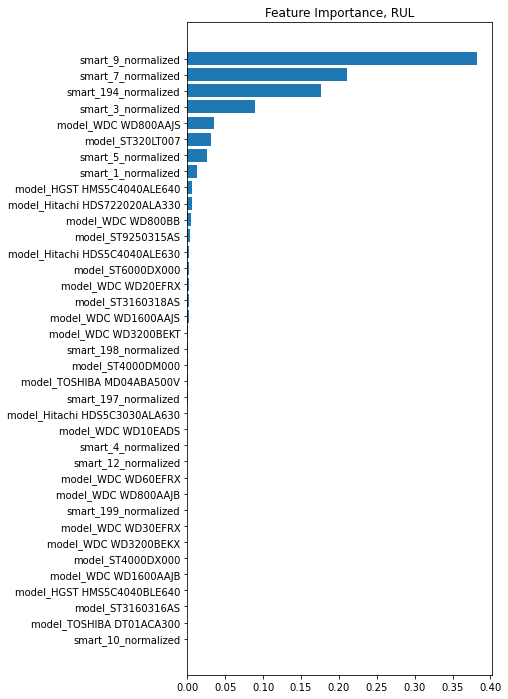

In [26]:
feature_importance = gbmtree.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance, RUL')

## Failure within time window

In [27]:
y = hDData_failures_data3.label1
X = hDData_failures_data3.drop(['RUL', 'label1'], axis='columns')
print(X.shape, y.shape)

(5490, 37) (5490,)


In [28]:
#f1_macro
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print('f1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

f1: 0.228 (0.044)


Text(0.5, 1.0, 'Feature Importance, failure within time window')

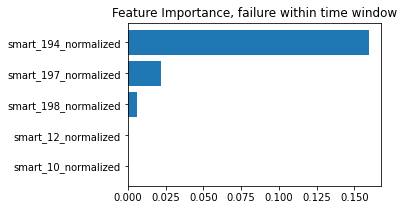

In [29]:
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(X, y)
feature_importance = model.feature_importances_[:5]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance, failure within time window')

In [30]:
X.describe()

,smart_10_normalized,smart_12_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,...,model_WDC WD1600AAJB,model_WDC WD1600AAJS,model_WDC WD20EFRX,model_WDC WD30EFRX,model_WDC WD3200BEKT,model_WDC WD3200BEKX,model_WDC WD60EFRX,model_WDC WD800AAJB,model_WDC WD800AAJS,model_WDC WD800BB
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.0,5490.000000,5490.000000,5490.000000,5490.000000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,99.960838,99.999818,58.025137,114.231876,104.031330,200.0,125.231330,103.631148,99.999818,113.423315,...,0.012750,0.011840,0.001093,0.037705,0.005829,0.008015,0.001093,0.001093,0.053188,0.009107
std,0.440809,0.013496,60.815441,35.012753,19.707659,0.0,31.343972,19.879653,0.013496,35.832316,...,0.112206,0.108174,0.033044,0.190499,0.076131,0.089173,0.033044,0.033044,0.224428,0.095006
min,95.000000,99.000000,16.000000,1.000000,81.000000,200.0,46.000000,88.000000,99.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,100.000000,24.000000,100.000000,100.000000,200.0,112.000000,92.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,100.000000,29.000000,100.000000,100.000000,200.0,117.000000,97.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,100.000000,39.000000,100.000000,100.000000,200.0,119.000000,100.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,253.000000,200.000000,200.000000,200.0,200.000000,253.000000,100.000000,200.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
X.apply(pd.Series.nunique)

smart_10_normalized               2
smart_12_normalized               2
smart_194_normalized             77
smart_197_normalized              6
smart_198_normalized              5
smart_199_normalized              1
smart_1_normalized               57
smart_3_normalized               46
smart_4_normalized                2
smart_5_normalized               39
smart_7_normalized               30
smart_9_normalized               59
model_HGST HMS5C4040ALE640        2
model_HGST HMS5C4040BLE640        2
model_Hitachi HDS5C3030ALA630     2
model_Hitachi HDS5C4040ALE630     2
model_Hitachi HDS722020ALA330     2
model_ST3160316AS                 2
model_ST3160318AS                 2
model_ST320LT007                  2
model_ST4000DM000                 2
model_ST4000DX000                 2
model_ST6000DX000                 2
model_ST9250315AS                 2
model_TOSHIBA DT01ACA300          2
model_TOSHIBA MD04ABA500V         2
model_WDC WD10EADS                2
model_WDC WD1600AAJB        